In [ ]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import numpy as np
import pandas as pd
import pickle
import numpy.linalg as lin
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import unicodedata
import warnings
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
file=open('/content/sentence.pkl','rb')
verse_embeddings_sentence=pickle.load(file)
file.close()
file=open('/content/max.pkl','rb')
verse_embeddings_max=pickle.load(file)
file.close()
file=open('/content/mean.pkl','rb')
verse_embeddings_mean=pickle.load(file)
file.close()
file=open('/content/whole.pkl','rb')
verse_embeddings_whole=pickle.load(file)
file.close()

In [ ]:
w2v = KeyedVectors.load_word2vec_format('/content/w2v.bin', binary=True)

## Preprocessing


In [ ]:
def remove_special_characters(text):
    regex = re.compile('[^a-zA-Z\s]')
    text_returned = re.sub(regex,' ',text)
    return text_returned

In [ ]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [ ]:
def word_embedding(word):
    word=word.lower()
    try:
        return w2v.get_vector(word)
    except:
        return np.array([0.0]*300)

In [ ]:
def cosine_similarity(a,b):
    try:
        return a.dot(b)/(lin.norm(a)*lin.norm(b))
    except:
        return -1.0

In [ ]:
def ed(a,b):
    return lin.norm(a-b)

In [ ]:
def sentence_embedding(sentence):
    sentence=strip_accents(sentence)
    sentence=remove_special_characters(sentence)
    words=word_tokenize(sentence)
    if len(words)>0:
        words=[word  for word in words if word not in stop_words]
        sentence_embedding=[word_embedding(word) for word in words]
        return np.array(list(map(lambda x: sum(x)/len(x), zip(*sentence_embedding))))
    return np.array([0]*300)

In [ ]:
data=pd.read_csv('/content/English.csv')

In [ ]:
query='Importance of bhagavad gita'
query_embedding=sentence_embedding(query)
query_embedding_list=query_embedding.reshape(1,-1).astype(np.float64)

##PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def apply_pca(embeddings, n_components=50):
    pca = PCA(n_components=n_components)
    embeddings_pca = pca.fit_transform(embeddings)
    return embeddings_pca, pca

In [ ]:
# Reduce dimensions for each embedding type (max, mean, whole)
verse_embeddings_max_pca, pca_max = apply_pca(verse_embeddings_max, n_components=10)
verse_embeddings_mean_pca, pca_mean = apply_pca(verse_embeddings_mean, n_components=10)
verse_embeddings_whole_pca, pca_whole = apply_pca(verse_embeddings_whole, n_components=10)

In [ ]:
# Perform KMeans clustering on PCA-reduced embeddings
def perform_kmeans(embeddings_pca, n_clusters=60):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(embeddings_pca)
    return kmeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_k, best_score = None, -1.0
results_k = []

# verse_embeddings_mean_pca is from the PCA cell above
Xpca = verse_embeddings_mean_pca

for k in range(2, 16):
    km = KMeans(n_clusters=k, random_state=42).fit(Xpca)
    score = silhouette_score(Xpca, km.labels_)
    results_k.append((k, score))
    if score > best_score:
        best_k, best_score = k, score

print(f"▶ Best k = {best_k} with silhouette = {best_score:.3f}\n")
print("All k vs. silhouette scores:")
for k, s in results_k:
    print(f"  k = {k:2d} → {s:.3f}")

# (Optional) store the best-k labels for later
km_best = KMeans(n_clusters=best_k, random_state=42).fit(Xpca)
data[f'Mean_Cluster_k{best_k}'] = km_best.labels_


▶ Best k = 3 with silhouette = 0.256

All k vs. silhouette scores:
  k =  2 → 0.249
  k =  3 → 0.256
  k =  4 → 0.242
  k =  5 → 0.239
  k =  6 → 0.218
  k =  7 → 0.226
  k =  8 → 0.225
  k =  9 → 0.206
  k = 10 → 0.194
  k = 11 → 0.189
  k = 12 → 0.185
  k = 13 → 0.180
  k = 14 → 0.185
  k = 15 → 0.181


In [ ]:
# Fit KMeans to PCA-reduced embeddings (max, mean, and whole)
kmeans_max = perform_kmeans(verse_embeddings_max_pca, n_clusters=3)
kmeans_mean = perform_kmeans(verse_embeddings_mean_pca, n_clusters=3)
kmeans_whole = perform_kmeans(verse_embeddings_whole_pca, n_clusters=3)

In [ ]:
# Define a function to predict cluster based on query embedding
def kmeans_cluster(query_embedding_pca, kmeans_model):
    label = kmeans_model.predict(query_embedding_pca)[0]
    verse_index = [i for i in range(len(kmeans_model.labels_)) if kmeans_model.labels_[i] == label]
    return verse_index

In [ ]:
# Apply PCA transformation to query embedding
query_embedding_list = query_embedding.reshape(1, -1).astype(np.float64)

query_embedding_max_pca = pca_max.transform(query_embedding_list)
query_embedding_mean_pca = pca_mean.transform(query_embedding_list)
query_embedding_whole_pca = pca_whole.transform(query_embedding_list)

In [ ]:
verse_index_max = kmeans_cluster(query_embedding_max_pca, kmeans_max)
data.loc[verse_index_max]

,Chapter,Verse,Sloka,Commentary,Topic,Mean_Embed_Cluster,Mean_Cluster_k3
0,1,1,धृतराष्ट्र उवाचधर्मक्षेत्रे कुरुक्षेत्रे समवेत...,Bhagavad-gītā is the widely read theistic scie...,0,44,0
1,1,2,सञ्जय उवाचदृष्ट्वा तु पाण्डवानीकं व्यूढं दुर्य...,Dhṛtarāṣṭra was blind from birth. Unfortunatel...,0,44,0
2,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् ।व्...,"Duryodhana, a great diplomat, wanted to point ...",0,44,0
3,1,4,अत्र श‍ूरा महेष्वासा भीमार्जुनसमा युधि ।युयुधा...,Even though Dhṛṣṭadyumna was not a very import...,0,28,0
4,1,8,भवान्भीष्मश्च कर्णश्च कृपश्च समितिंजयः ।अश्वत्...,Duryodhana mentions the exceptional heroes in ...,0,15,0
...,...,...,...,...,...,...,...
586,18,67,इदं ते नातपस्काय नाभक्ताय कदाचन ।न चाश‍ुश्रूषव...,Persons who have not undergone the austerities...,0,37,1
589,18,72,कच्च‍िदेतच्छ्रुतं पार्थ त्वयैकाग्रेण चेतसा ।कच...,The Lord was acting as the spiritual master of...,0,0,1
592,18,75,व्यासप्रसादाच्छ्रुतवानेतद्‍गुह्यमहं परम् ।योगं...,"Vyāsa was the spiritual master of Sañjaya, and...",0,0,1
593,18,76,राजन्संस्मृत्य संस्मृत्य संवादमिममद्भुतम् ।केश...,The understanding of Bhagavad-gītā is so trans...,0,10,1


In [ ]:
verse_index_mean = kmeans_cluster(query_embedding_mean_pca, kmeans_mean)
data.loc[verse_index_mean]

,Chapter,Verse,Sloka,Commentary,Topic,Mean_Embed_Cluster,Mean_Cluster_k3
0,1,1,धृतराष्ट्र उवाचधर्मक्षेत्रे कुरुक्षेत्रे समवेत...,Bhagavad-gītā is the widely read theistic scie...,0,44,0
1,1,2,सञ्जय उवाचदृष्ट्वा तु पाण्डवानीकं व्यूढं दुर्य...,Dhṛtarāṣṭra was blind from birth. Unfortunatel...,0,44,0
2,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् ।व्...,"Duryodhana, a great diplomat, wanted to point ...",0,44,0
3,1,4,अत्र श‍ूरा महेष्वासा भीमार्जुनसमा युधि ।युयुधा...,Even though Dhṛṣṭadyumna was not a very import...,0,28,0
4,1,8,भवान्भीष्मश्च कर्णश्च कृपश्च समितिंजयः ।अश्वत्...,Duryodhana mentions the exceptional heroes in ...,0,15,0
...,...,...,...,...,...,...,...
556,18,28,अयुक्त: प्राकृत: स्तब्ध: शठो नैष्कृतिकोऽलस: ।व...,In the scriptural injunctions we find what sor...,0,43,0
562,18,35,यया स्वप्‍नं भयं शोकं विषादं मदमेव च ।न विमुञ्...,It should not be concluded that a person in th...,0,7,0
565,18,38,विषयेन्द्रियसंयोगाद्यत्तदग्रेऽमृतोपमम् ।परिणाम...,"A young man and a young woman meet, and the se...",0,7,0
569,18,47,श्रेयान्स्वधर्मो विगुण: परधर्मात्स्वनुष्ठितात्...,One’s occupational duty is prescribed in Bhaga...,0,13,0


In [ ]:
verse_index_whole = kmeans_cluster(query_embedding_whole_pca, kmeans_whole)
data.loc[verse_index_whole]

,Chapter,Verse,Sloka,Commentary,Topic,Mean_Embed_Cluster,Mean_Cluster_k3
0,1,1,धृतराष्ट्र उवाचधर्मक्षेत्रे कुरुक्षेत्रे समवेत...,Bhagavad-gītā is the widely read theistic scie...,0,44,0
1,1,2,सञ्जय उवाचदृष्ट्वा तु पाण्डवानीकं व्यूढं दुर्य...,Dhṛtarāṣṭra was blind from birth. Unfortunatel...,0,44,0
2,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् ।व्...,"Duryodhana, a great diplomat, wanted to point ...",0,44,0
3,1,4,अत्र श‍ूरा महेष्वासा भीमार्जुनसमा युधि ।युयुधा...,Even though Dhṛṣṭadyumna was not a very import...,0,28,0
4,1,8,भवान्भीष्मश्च कर्णश्च कृपश्च समितिंजयः ।अश्वत्...,Duryodhana mentions the exceptional heroes in ...,0,15,0
...,...,...,...,...,...,...,...
555,18,27,रागी कर्मफलप्रेप्सुर्लुब्धो हिंसात्मकोऽश‍ुचि: ...,A person is too much attached to a certain kin...,0,43,0
556,18,28,अयुक्त: प्राकृत: स्तब्ध: शठो नैष्कृतिकोऽलस: ।व...,In the scriptural injunctions we find what sor...,0,43,0
565,18,38,विषयेन्द्रियसंयोगाद्यत्तदग्रेऽमृतोपमम् ।परिणाम...,"A young man and a young woman meet, and the se...",0,7,0
569,18,47,श्रेयान्स्वधर्मो विगुण: परधर्मात्स्वनुष्ठितात्...,One’s occupational duty is prescribed in Bhaga...,0,13,0


In [ ]:
from sklearn.decomposition import PCA

dims = [10, 30, 50, 75, 100]
results_dim = []

# verse_embeddings_mean is your original mean-pooled matrix
Xraw = verse_embeddings_mean

for d in dims:
    pca = PCA(n_components=d, random_state=42).fit(Xraw)
    Xd = pca.transform(Xraw)
    km = KMeans(n_clusters=best_k, random_state=42).fit(Xd)
    score = silhouette_score(Xd, km.labels_)
    results_dim.append((d, score))

print(f"▶ PCA dim vs. silhouette (using k = {best_k}):")
for d, s in results_dim:
    print(f"  dim = {d:3d} → {s:.3f}")


▶ PCA dim vs. silhouette (using k = 3):
  dim =  10 → 0.256
  dim =  30 → 0.255
  dim =  50 → 0.255
  dim =  75 → 0.255
  dim = 100 → 0.255


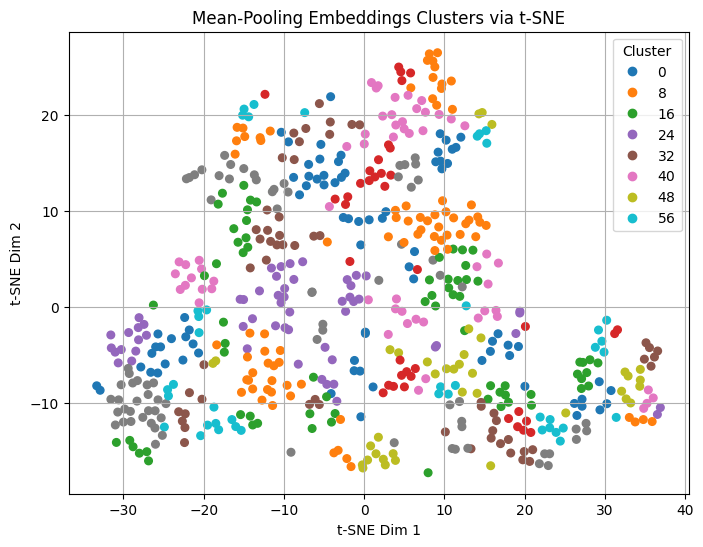

In [ ]:
# —— t-SNE visualization for mean-pool clusters only ——
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

mean_2d = TSNE(n_components=2, perplexity=30, random_state=42) \
          .fit_transform(verse_embeddings_mean_pca)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    mean_2d[:,0], mean_2d[:,1],
    c=data['Mean_Embed_Cluster'],
    cmap='tab10', s=30
)
plt.title("Mean-Pooling Embeddings Clusters via t-SNE")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.show()


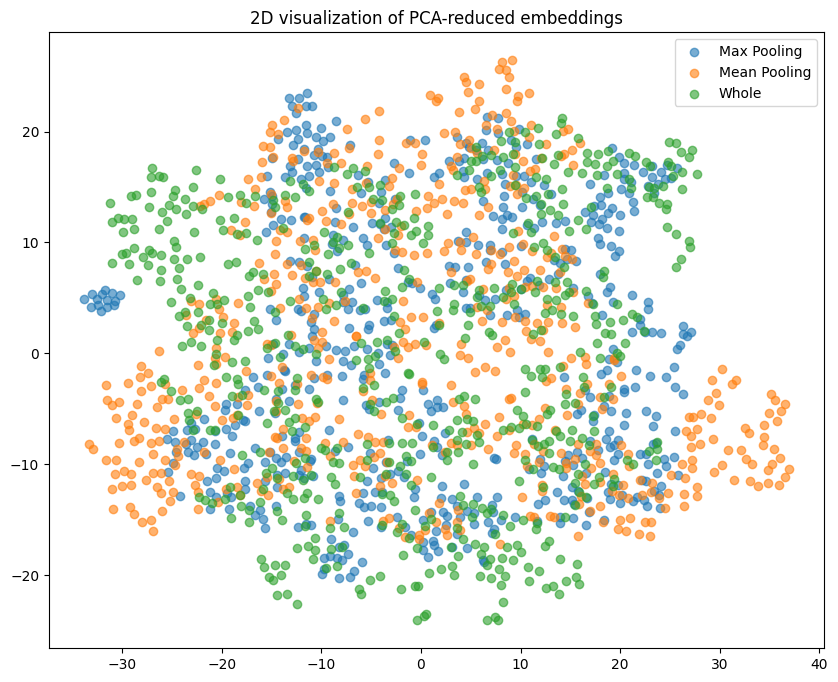

In [ ]:
# Step 1: Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=0)

# Apply t-SNE to the PCA-reduced embeddings (50D) for visualization
verse_embeddings_max_2d = tsne.fit_transform(verse_embeddings_max_pca)
verse_embeddings_mean_2d = tsne.fit_transform(verse_embeddings_mean_pca)
verse_embeddings_whole_2d = tsne.fit_transform(verse_embeddings_whole_pca)


plt.figure(figsize=(10, 8))

# Max Pooling embeddings
plt.scatter(verse_embeddings_max_2d[:, 0], verse_embeddings_max_2d[:, 1], label="Max Pooling", alpha=0.6)
# Mean Pooling embeddings
plt.scatter(verse_embeddings_mean_2d[:, 0], verse_embeddings_mean_2d[:, 1], label="Mean Pooling", alpha=0.6)
# Whole embeddings
plt.scatter(verse_embeddings_whole_2d[:, 0], verse_embeddings_whole_2d[:, 1], label="Whole", alpha=0.6)

plt.title("2D visualization of PCA-reduced embeddings")
plt.legend()
plt.show()

##Clustering

max pooling

In [ ]:
kmeans_max = KMeans(n_clusters=60, random_state=0).fit(verse_embeddings_max)

In [ ]:
def kmeans_max_cluster(query_embedding_list):
    label=kmeans_max.predict(query_embedding_list)[0]
    verse_index=[i for i in range(len(data)) if kmeans_max.labels_[i]==label]
    return verse_index

In [ ]:
verse_index=kmeans_max_cluster(query_embedding_list)
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
4,1,8,भवान्भीष्मश्च कर्णश्च कृपश्च समितिंजयः ।अश्वत्...,Duryodhana mentions the exceptional heroes in ...,0,15
25,1,42,दोषैरेतैः कुलघ्न‍ानां वर्णसङ्करकारकैः ।उत्साद्...,Community projects for the four orders of huma...,0,44
34,2,5,गुरूनहत्वा हि महानुभावान्श्रेयो भोक्तुं भैक्ष्...,"According to scriptural codes, a teacher who e...",0,44
222,6,19,यथा दीपो निवातस्थो नेङ्गते सोपमा स्मृता ।योगिन...,"A truly Kṛṣṇa conscious person, always absorbe...",0,41
384,11,12,दिवि सूर्यसहस्रस्य भवेद्युगपदुत्थिता ।यदि भा: ...,"What Arjuna saw was indescribable, yet Sañjaya...",0,44
391,11,21,अमी हि त्वां सुरसङ्घा विशन्तिकेचिद्भ‍ीता: प्रा...,The demigods in all the planetary systems fear...,0,31
521,17,18,सत्कारमानपूजार्थं तपो दम्भेन चैव यत् ।क्रियते ...,Sometimes penance and austerity are executed t...,0,43


mean pooling

In [ ]:
kmeans_mean = KMeans(n_clusters=60, random_state=0).fit(verse_embeddings_mean)

In [ ]:
def kmeans_mean_cluster(query_embedding_list):
    label=kmeans_mean.predict(query_embedding_list)[0]
    verse_index=[i for i in range(len(data)) if kmeans_mean.labels_[i]==label]
    return verse_index

In [ ]:
verse_index=kmeans_mean_cluster(query_embedding_list)
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
0,1,1,धृतराष्ट्र उवाचधर्मक्षेत्रे कुरुक्षेत्रे समवेत...,Bhagavad-gītā is the widely read theistic scie...,0,44
1,1,2,सञ्जय उवाचदृष्ट्वा तु पाण्डवानीकं व्यूढं दुर्य...,Dhṛtarāṣṭra was blind from birth. Unfortunatel...,0,44
2,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् ।व्...,"Duryodhana, a great diplomat, wanted to point ...",0,44
6,1,10,अपर्याप्त‍ं तदस्माकं बलं भीष्माभिरक्षितम् ।पर्...,Herein an estimation of comparative strength i...,0,44
7,1,11,अयनेषु च सर्वेषु यथाभागवमस्थिताः ।भीष्ममेवाभिर...,"Duryodhana, after praising the prowess of Bhīṣ...",0,44
8,1,12,तस्य सञ्जनयन्हर्षं कुरुवृद्धः पितामहः ।सिंहनाद...,The grandsire of the Kuru dynasty could unders...,0,44
9,1,14,ततः श्वेतैर्हयैर्युक्ते महति स्यन्दने स्थितौ ।...,In contrast with the conchshell blown by Bhīṣm...,0,44
17,1,28,अर्जुन उवाचदृष्ट्वेमं स्वजनं कृष्ण युयुत्सुं स...,Any man who has genuine devotion to the Lord h...,0,44
21,1,36,पापमेवाश्रयेदस्मान्हत्वैतानाततायिनः ।तस्मान्ना...,According to Vedic injunctions there are six k...,0,44
25,1,42,दोषैरेतैः कुलघ्न‍ानां वर्णसङ्करकारकैः ।उत्साद्...,Community projects for the four orders of huma...,0,44


Whole

In [ ]:
kmeans_whole = KMeans(n_clusters=60, random_state=0).fit(verse_embeddings_whole)

In [ ]:
def kmeans_whole_cluster(query_embedding_list):
    label=kmeans_whole.predict(query_embedding_list)[0]
    verse_index=[i for i in range(len(data)) if kmeans_whole.labels_[i]==label]
    return verse_index

In [ ]:
verse_index=kmeans_whole_cluster(query_embedding_list)
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
5,1,9,अन्ये च बहवः श‍ूरा मदर्थे त्यक्तजीविताः ।नानाश...,As far as the others are concerned – like Jaya...,0,28
13,1,23,योत्स्यमानानवेक्षेऽहं य एतेऽत्र समागताः ।धार्त...,It was an open secret that Duryodhana wanted t...,0,28
16,1,26,तत्रापश्यत्स्थितान्पार्थः पितॄनथ पितामहान्।आचा...,On the battlefield Arjuna could see all kinds ...,0,9
62,2,33,अथ चेत्त्वमिमं धर्म्यं सङ्ग्रामं न करिष्यसि ।त...,"Arjuna was a famous fighter, and he attained f...",0,28
63,2,34,अकीर्तिं चापि भूतानि कथयिष्यन्ति तेऽव्ययाम् ।स...,"Both as friend and philosopher to Arjuna, Lord...",0,28


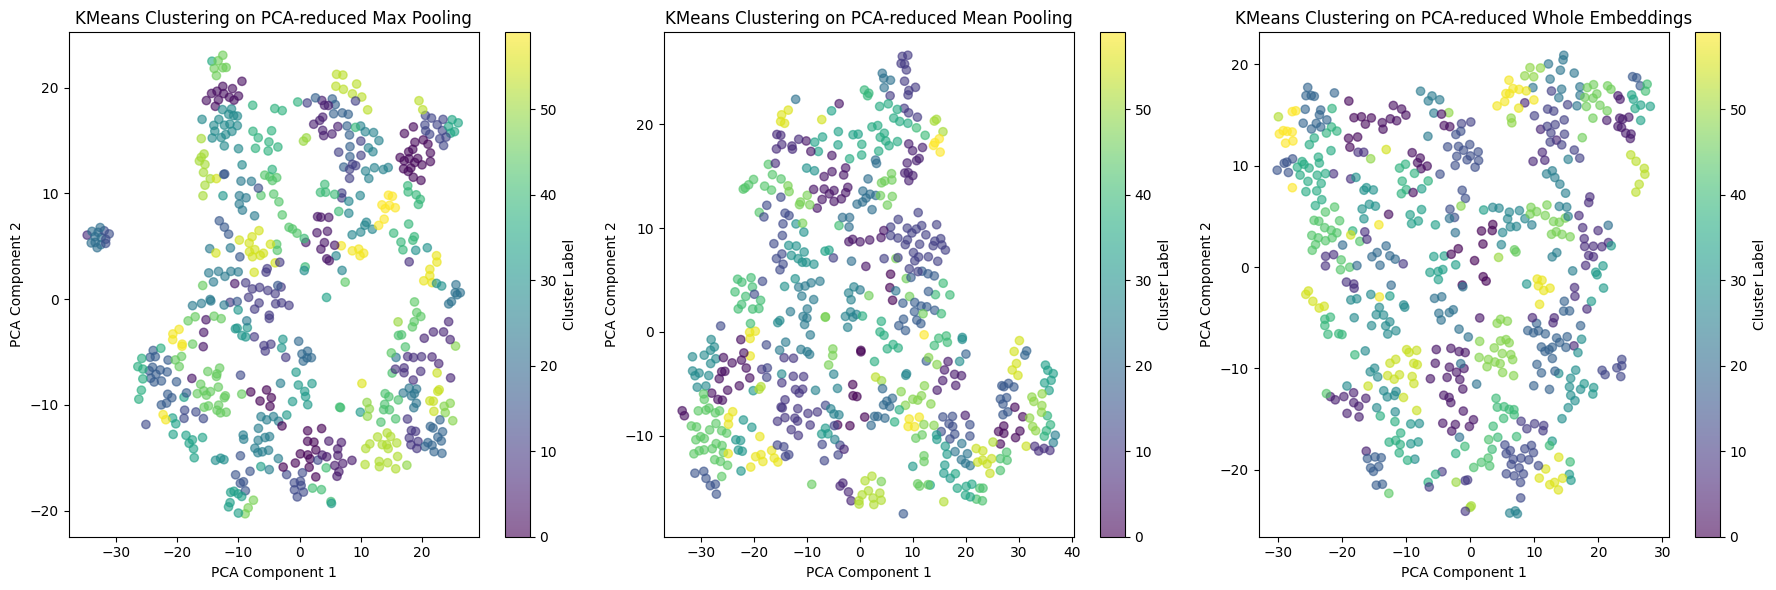

In [ ]:
# Perform KMeans clustering for each set of embeddings (Max, Mean, Whole)
kmeans_max = KMeans(n_clusters=60, random_state=0).fit(verse_embeddings_max_pca)
kmeans_mean = KMeans(n_clusters=60, random_state=0).fit(verse_embeddings_mean_pca)
kmeans_whole = KMeans(n_clusters=60, random_state=0).fit(verse_embeddings_whole_pca)

# Create a figure with subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Max Pooling clustering plot
scatter_max = axs[0].scatter(verse_embeddings_max_2d[:, 0], verse_embeddings_max_2d[:, 1], c=kmeans_max.labels_, cmap='viridis', alpha=0.6)
axs[0].set_title("KMeans Clustering on PCA-reduced Max Pooling")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")
fig.colorbar(scatter_max, ax=axs[0], label='Cluster Label')

# Mean Pooling clustering plot
scatter_mean = axs[1].scatter(verse_embeddings_mean_2d[:, 0], verse_embeddings_mean_2d[:, 1], c=kmeans_mean.labels_, cmap='viridis', alpha=0.6)
axs[1].set_title("KMeans Clustering on PCA-reduced Mean Pooling")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")
fig.colorbar(scatter_mean, ax=axs[1], label='Cluster Label')

# Whole embeddings clustering plot
scatter_whole = axs[2].scatter(verse_embeddings_whole_2d[:, 0], verse_embeddings_whole_2d[:, 1], c=kmeans_whole.labels_, cmap='viridis', alpha=0.6)
axs[2].set_title("KMeans Clustering on PCA-reduced Whole Embeddings")
axs[2].set_xlabel("PCA Component 1")
axs[2].set_ylabel("PCA Component 2")
fig.colorbar(scatter_whole, ax=axs[2], label='Cluster Label')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()



##MAX STRAT

COS SIM

In [ ]:
def max_cosine(query_embedding,counter=10):
    scoring=[cosine_similarity(query_embedding,i) for i in verse_embeddings_max]
    verse_index=np.argsort(scoring)[-1::-1][:counter]
    return verse_index

In [ ]:
verse_index=max_cosine(query_embedding)

In [ ]:
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
2,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् ।व्...,"Duryodhana, a great diplomat, wanted to point ...",0,44
19,1,30,न च शक्न‍ोम्यवस्थातुं भ्रमतीव च मे मनः ।निमित्...,"Due to his impatience, Arjuna was unable to st...",0,2
4,1,8,भवान्भीष्मश्च कर्णश्च कृपश्च समितिंजयः ।अश्वत्...,Duryodhana mentions the exceptional heroes in ...,0,15
65,2,36,अवाच्यवादांश्च बहून्वदिष्यन्ति तवाहिताः ।निन्द...,Lord Kṛṣṇa was astonished in the beginning at ...,0,44
360,10,27,उच्‍चैःश्रवसमश्वानां विद्धि माममृतोद्भ‍वम् ।ऐर...,The devotee demigods and the demons (asuras) o...,0,44
16,1,26,तत्रापश्यत्स्थितान्पार्थः पितॄनथ पितामहान्।आचा...,On the battlefield Arjuna could see all kinds ...,0,9
66,2,37,हतो वा प्राप्स्यसि स्वर्ग जित्वा वा भोक्ष्यसे ...,Even though there was no certainty of victory ...,1,50
532,18,3,त्याज्यं दोषवदित्येके कर्म प्राहुर्मनीषिण: ।यज...,There are many activities in the Vedic literat...,0,30
5,1,9,अन्ये च बहवः श‍ूरा मदर्थे त्यक्तजीविताः ।नानाश...,As far as the others are concerned – like Jaya...,0,28
64,2,35,भयाद्रणादुपरतं मंस्यन्ते त्वां महारथाः ।येषां ...,Lord Kṛṣṇa continued to give His verdict to Ar...,0,57


Euclidean Distance

In [ ]:
def max_ed(query_embedding,counter=10):
    scoring=[ed(query_embedding,i) for i in verse_embeddings_max]
    verse_index=np.argsort(scoring)[:counter]
    return verse_index

In [ ]:
verse_index=max_ed(query_embedding)

In [ ]:
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
65,2,36,अवाच्यवादांश्च बहून्वदिष्यन्ति तवाहिताः ।निन्द...,Lord Kṛṣṇa was astonished in the beginning at ...,0,44
5,1,9,अन्ये च बहवः श‍ूरा मदर्थे त्यक्तजीविताः ।नानाश...,As far as the others are concerned – like Jaya...,0,28
4,1,8,भवान्भीष्मश्च कर्णश्च कृपश्च समितिंजयः ।अश्वत्...,Duryodhana mentions the exceptional heroes in ...,0,15
25,1,42,दोषैरेतैः कुलघ्न‍ानां वर्णसङ्करकारकैः ।उत्साद्...,Community projects for the four orders of huma...,0,44
64,2,35,भयाद्रणादुपरतं मंस्यन्ते त्वां महारथाः ।येषां ...,Lord Kṛṣṇa continued to give His verdict to Ar...,0,57
384,11,12,दिवि सूर्यसहस्रस्य भवेद्युगपदुत्थिता ।यदि भा: ...,"What Arjuna saw was indescribable, yet Sañjaya...",0,44
2,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् ।व्...,"Duryodhana, a great diplomat, wanted to point ...",0,44
391,11,21,अमी हि त्वां सुरसङ्घा विशन्तिकेचिद्भ‍ीता: प्रा...,The demigods in all the planetary systems fear...,0,31
6,1,10,अपर्याप्त‍ं तदस्माकं बलं भीष्माभिरक्षितम् ।पर्...,Herein an estimation of comparative strength i...,0,44
377,11,2,भवाप्ययौ हि भूतानां श्रुतौ विस्तरशो मया ।त्वत्...,Arjuna addresses Lord Kṛṣṇa as “lotus-eyed” (K...,0,57


##Mean Pooling

Cosine Similarity

In [ ]:
def mean_cosine(query_embedding,counter=10):
    scoring=[cosine_similarity(query_embedding,i) for i in verse_embeddings_mean]
    verse_index=np.argsort(scoring)[-1::-1][:counter]
    return verse_index

In [ ]:
verse_index=mean_cosine(query_embedding)

In [ ]:
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
2,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् ।व्...,"Duryodhana, a great diplomat, wanted to point ...",0,44
4,1,8,भवान्भीष्मश्च कर्णश्च कृपश्च समितिंजयः ।अश्वत्...,Duryodhana mentions the exceptional heroes in ...,0,15
62,2,33,अथ चेत्त्वमिमं धर्म्यं सङ्ग्रामं न करिष्यसि ।त...,"Arjuna was a famous fighter, and he attained f...",0,28
16,1,26,तत्रापश्यत्स्थितान्पार्थः पितॄनथ पितामहान्।आचा...,On the battlefield Arjuna could see all kinds ...,0,9
33,2,4,अर्जुन उवाचकथं भीष्ममहं संख्ये द्रोणं च मधुसूद...,Respectable superiors like Bhīṣma the grandfat...,0,44
66,2,37,हतो वा प्राप्स्यसि स्वर्ग जित्वा वा भोक्ष्यसे ...,Even though there was no certainty of victory ...,1,50
3,1,4,अत्र श‍ूरा महेष्वासा भीमार्जुनसमा युधि ।युयुधा...,Even though Dhṛṣṭadyumna was not a very import...,0,28
63,2,34,अकीर्तिं चापि भूतानि कथयिष्यन्ति तेऽव्ययाम् ।स...,"Both as friend and philosopher to Arjuna, Lord...",0,28
13,1,23,योत्स्यमानानवेक्षेऽहं य एतेऽत्र समागताः ।धार्त...,It was an open secret that Duryodhana wanted t...,0,28
385,11,13,तत्रैकस्थं जगत्कृत्स्नं प्रविभक्तमनेकधा ।अपश्य...,The word tatra (“there”) is very significant. ...,1,20


Euclidean Distance

In [ ]:
def mean_ed(query_embedding,counter=10):
    scoring=[ed(query_embedding,i) for i in verse_embeddings_mean]
    verse_index=np.argsort(scoring)[:counter]
    return verse_index

In [ ]:
verse_index=mean_ed(query_embedding)

In [ ]:
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
33,2,4,अर्जुन उवाचकथं भीष्ममहं संख्ये द्रोणं च मधुसूद...,Respectable superiors like Bhīṣma the grandfat...,0,44
2,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् ।व्...,"Duryodhana, a great diplomat, wanted to point ...",0,44
63,2,34,अकीर्तिं चापि भूतानि कथयिष्यन्ति तेऽव्ययाम् ।स...,"Both as friend and philosopher to Arjuna, Lord...",0,28
13,1,23,योत्स्यमानानवेक्षेऽहं य एतेऽत्र समागताः ।धार्त...,It was an open secret that Duryodhana wanted t...,0,28
62,2,33,अथ चेत्त्वमिमं धर्म्यं सङ्ग्रामं न करिष्यसि ।त...,"Arjuna was a famous fighter, and he attained f...",0,28
360,10,27,उच्‍चैःश्रवसमश्वानां विद्धि माममृतोद्भ‍वम् ।ऐर...,The devotee demigods and the demons (asuras) o...,0,44
5,1,9,अन्ये च बहवः श‍ूरा मदर्थे त्यक्तजीविताः ।नानाश...,As far as the others are concerned – like Jaya...,0,28
357,10,24,पुरोधसां च मुख्यं मां विद्धि पार्थ बृहस्पतिम् ...,Indra is the chief demigod of the heavenly pla...,0,44
384,11,12,दिवि सूर्यसहस्रस्य भवेद्युगपदुत्थिता ।यदि भा: ...,"What Arjuna saw was indescribable, yet Sañjaya...",0,44
6,1,10,अपर्याप्त‍ं तदस्माकं बलं भीष्माभिरक्षितम् ।पर्...,Herein an estimation of comparative strength i...,0,44


##Line Matching

Cosine Similarity

In [ ]:
def line_cosine(query_embeddings,counter=10):
    scoring=[]
    for embeddings in verse_embeddings_sentence:
        score=[cosine_similarity(query_embedding,embed) for embed in embeddings]
        scoring.append(max(score))
    verse_index=np.argsort(scoring)[-1::-1][:counter]
    return verse_index

In [ ]:
verse_index=line_cosine(query_embedding)
data.loc[verse_index]

<ipython-input-8-53c6543d6d97>:3: RuntimeWarning: invalid value encountered in scalar divide
  return a.dot(b)/(lin.norm(a)*lin.norm(b))


,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
20,1,31,न च श्रेयोऽनुपश्यामि हत्वा स्वजनमाहवे ।न काङ्क...,Without knowing that one’s self-interest is in...,0,28
2,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् ।व्...,"Duryodhana, a great diplomat, wanted to point ...",0,44
17,1,28,अर्जुन उवाचदृष्ट्वेमं स्वजनं कृष्ण युयुत्सुं स...,Any man who has genuine devotion to the Lord h...,0,44
29,1,46,सञ्जय उवाचएवमुक्त्वार्जुनः संख्ये रथोपस्थ उपाव...,"While observing the situation of his enemy, Ar...",0,44
13,1,23,योत्स्यमानानवेक्षेऽहं य एतेऽत्र समागताः ।धार्त...,It was an open secret that Duryodhana wanted t...,0,28
308,9,5,न च मत्स्थानि भूतानि पश्य मे योगमैश्वरम् ।भूतभ...,The Lord says that everything is resting on Hi...,0,12
19,1,30,न च शक्न‍ोम्यवस्थातुं भ्रमतीव च मे मनः ।निमित्...,"Due to his impatience, Arjuna was unable to st...",0,2
428,13,5,ऋषिभिर्बहुधा गीतं छन्दोभिर्विविधै: पृथक् ।ब्रह...,"The Supreme Personality of Godhead, Kṛṣṇa, is ...",2,35
38,2,9,सञ्जय उवाचएवमुक्त्वा हृषीकेशं गुडाकेशः परन्तपः...,Dhṛtarāṣṭra must have been very glad to unders...,0,9
392,11,32,श्रीभगवानुवाचकालोऽस्मि लोकक्षयकृत्प्रवृद्धोलोक...,Although Arjuna knew that Kṛṣṇa was his friend...,0,9


Euclidean Distance

In [ ]:
def line_ed(query_embeddings,counter=10):
    scoring=[]
    for embeddings in verse_embeddings_sentence:
        score=[ed(query_embedding,embed) for embed in embeddings]
        scoring.append(max(score))
    verse_index=np.argsort(scoring)[:counter]
    return verse_index

In [ ]:
verse_index=line_ed(query_embedding)
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
5,1,9,अन्ये च बहवः श‍ूरा मदर्थे त्यक्तजीविताः ।नानाश...,As far as the others are concerned – like Jaya...,0,28
25,1,42,दोषैरेतैः कुलघ्न‍ानां वर्णसङ्करकारकैः ।उत्साद्...,Community projects for the four orders of huma...,0,44
384,11,12,दिवि सूर्यसहस्रस्य भवेद्युगपदुत्थिता ।यदि भा: ...,"What Arjuna saw was indescribable, yet Sañjaya...",0,44
391,11,21,अमी हि त्वां सुरसङ्घा विशन्तिकेचिद्भ‍ीता: प्रा...,The demigods in all the planetary systems fear...,0,31
65,2,36,अवाच्यवादांश्च बहून्वदिष्यन्ति तवाहिताः ।निन्द...,Lord Kṛṣṇa was astonished in the beginning at ...,0,44
22,1,39,कुलक्षये प्रणश्यन्ति कुलधर्माः सनातनाः ।धर्मे ...,In the system of the varṇāśrama institution th...,0,28
3,1,4,अत्र श‍ूरा महेष्वासा भीमार्जुनसमा युधि ।युयुधा...,Even though Dhṛṣṭadyumna was not a very import...,0,28
377,11,2,भवाप्ययौ हि भूतानां श्रुतौ विस्तरशो मया ।त्वत्...,Arjuna addresses Lord Kṛṣṇa as “lotus-eyed” (K...,0,57
8,1,12,तस्य सञ्जनयन्हर्षं कुरुवृद्धः पितामहः ।सिंहनाद...,The grandsire of the Kuru dynasty could unders...,0,44
222,6,19,यथा दीपो निवातस्थो नेङ्गते सोपमा स्मृता ।योगिन...,"A truly Kṛṣṇa conscious person, always absorbe...",0,41


##Whole Part

cos sim

In [ ]:
def whole_cosine(query_embedding,counter=10):
    scoring=[cosine_similarity(query_embedding,i) for i in verse_embeddings_whole]
    verse_index=np.argsort(scoring)[-1::-1][:counter]
    return verse_index

In [ ]:
verse_index=whole_cosine(query_embedding)
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
2,1,3,पश्यैतां पाण्डुपुत्राणामाचार्य महतीं चमूम् ।व्...,"Duryodhana, a great diplomat, wanted to point ...",0,44
4,1,8,भवान्भीष्मश्च कर्णश्च कृपश्च समितिंजयः ।अश्वत्...,Duryodhana mentions the exceptional heroes in ...,0,15
16,1,26,तत्रापश्यत्स्थितान्पार्थः पितॄनथ पितामहान्।आचा...,On the battlefield Arjuna could see all kinds ...,0,9
62,2,33,अथ चेत्त्वमिमं धर्म्यं सङ्ग्रामं न करिष्यसि ।त...,"Arjuna was a famous fighter, and he attained f...",0,28
3,1,4,अत्र श‍ूरा महेष्वासा भीमार्जुनसमा युधि ।युयुधा...,Even though Dhṛṣṭadyumna was not a very import...,0,28
66,2,37,हतो वा प्राप्स्यसि स्वर्ग जित्वा वा भोक्ष्यसे ...,Even though there was no certainty of victory ...,1,50
33,2,4,अर्जुन उवाचकथं भीष्ममहं संख्ये द्रोणं च मधुसूद...,Respectable superiors like Bhīṣma the grandfat...,0,44
63,2,34,अकीर्तिं चापि भूतानि कथयिष्यन्ति तेऽव्ययाम् ।स...,"Both as friend and philosopher to Arjuna, Lord...",0,28
13,1,23,योत्स्यमानानवेक्षेऽहं य एतेऽत्र समागताः ।धार्त...,It was an open secret that Duryodhana wanted t...,0,28
385,11,13,तत्रैकस्थं जगत्कृत्स्नं प्रविभक्तमनेकधा ।अपश्य...,The word tatra (“there”) is very significant. ...,1,20


elucidean dist

In [ ]:
def whole_ed(query_embedding,counter=10):
    scoring=[cosine_similarity(query_embedding,i) for i in verse_embeddings_whole]
    verse_index=np.argsort(scoring)[:counter]
    return verse_index

In [ ]:
verse_index=whole_ed(query_embedding)
data.loc[verse_index]

,Chapter,Verse,Sloke,Commentary,Mean_Cluster_k3,Mean_Embed_Cluster
456,14,5,सत्त्वं रजस्तम इति गुणा: प्रकृतिसम्भवा: ।निबध्...,"The living entity, because he is transcendenta...",2,25
443,13,27,यावत्सञ्जायते किञ्चित्सत्त्वं स्थावरजङ्गमम् ।क...,"Both material nature and the living entity, wh...",2,25
436,13,20,प्रकृतिं पुरुषं चैव विद्ध्यनादी उभावपि ।विकारा...,"By the knowledge given in this chapter, one ca...",2,8
567,18,40,न तदस्ति पृथिव्यां वा दिवि देवेषु वा पुन: ।सत्...,The Lord here summarizes the total influence o...,2,49
448,13,32,अनादित्वान्निर्गुणत्वात्परमात्मायमव्यय: ।शरीरस...,A living entity appears to be born because of ...,2,49
295,8,20,परस्तस्मात्तु भावोऽन्योऽव्यक्तोऽव्यक्तात्सनातन...,"Kṛṣṇa’s superior, spiritual energy is transcen...",2,38
388,11,16,अनेकबाहूदरवक्‍त्रनेत्रंपश्यामि त्वां सर्वतोऽनन...,Kṛṣṇa is the Supreme Personality of Godhead an...,2,18
455,14,4,सर्वयोनिषु कौन्तेय मूर्तय: सम्भवन्ति या: ।तासा...,In this verse it is clearly explained that the...,2,8
93,2,67,इन्द्रियाणां हि चरतां यन्मनोऽनुविधीयते ।तदस्य ...,Unless all of the senses are engaged in the se...,1,22
437,13,21,कार्यकारणकर्तृत्वे हेतु: प्रकृतिरुच्यते ।पुरुष...,The different manifestations of body and sense...,2,1
